Download Dataset

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d moeinkpr/snappfood-comments

!unzip snappfood-comments.zip

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Dataset URL: https://www.kaggle.com/datasets/moeinkpr/snappfood-comments
License(s): MIT
  0% 0.00/98.1M [00:00<?, ?B/s]
100% 98.1M/98.1M [00:00<00:00, 1.60GB/s]
Archive:  snappfood-comments.zip
  inflating: comments.csv            
  inflating: vendors.csv             
Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 16.61 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.11 environment at: /usr
Resolved 180 packages in 11.74s
Prepared 41 packages in 1m 00s
Uninstalled 31 packages in 1.11s
Installed 41 packages in 414ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.3
 + cuda-pathfinder==1.3.0
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.3


Import libraries

In [ ]:
import cudf
from cuml.preprocessing import LabelEncoder
import cudf
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

Import & Read data

In [ ]:
comments_table = cudf.read_csv("comments.csv")
vendors_table = cudf.read_csv("vendors.csv")

# فیلد هایی که ارزش تحلیلی ندارند را حذف می کنیم تا جچم دیتا کاهش یابد و مدل سریع تر و بهینه تر آموزش یابد
comments_table = comments_table.drop(columns=["commentId","date","sender","rating","customerId","feeling","status","foods","replies"], errors="ignore")
vendors_table = vendors_table.drop(columns=["id","highlight","description","address","rating","title"], errors="ignore")

# دو جدول را بر اساس کد رستوران مرج می کنیم
merged_df = comments_table.merge(vendors_table, on="code", how="left")
# در دیتاست فقط رستوران ها رو انتخاب می کنیم و بعد از آن ستون vendorType را حذف می کنیم
merged_df = merged_df[merged_df["vendorType"] == "RESTAURANT"]
merged_df = merged_df.drop(columns=["vendorType"])

# دو ستون که مربط به کامنت ها بودند را مرج می کنیم تا همه کامنت ها را بررسی کنیم
# در ستون deliveryComment مقدار زیادی فیلد خالی وجود دارد
# برای این که در توسعه مدل اختلالی  وجود نیاید آن را با یک رشته خالی پر می کنیم
merged_df["deliveryComment"] = merged_df["deliveryComment"].fillna("")
merged_df["commentText"] = merged_df["commentText"].fillna("")

merged_df["text_raw"] = merged_df["commentText"] + " " + merged_df["deliveryComment"]
merged_df = merged_df.drop(columns=["commentText", "deliveryComment"])

# چون هدف ما این است که بصورت هفتگی روند رستوران ها را بررسی کنیم ستونی که مربوط به زمان ایجاد کامنت هست را به سال و هفته تقسیم می کنیم
merged_df["createdDate"] = cudf.to_datetime(merged_df["createdDate"])
merged_df["week"] = merged_df["createdDate"].dt.isocalendar().week.astype("int32")
merged_df["year"] = merged_df["createdDate"].dt.year.astype("int32")


<class 'cudf.core.dataframe.DataFrame'>
Index: 1078372 entries, 0 to 1290548
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype
---  ------                  --------------    -----
 0   createdDate             1078372 non-null  datetime64[ns]
 1   rate                    1078372 non-null  uint8
 2   code                    1078372 non-null  object
 3   commentCount            1078372 non-null  object
 4   text_raw                1078372 non-null  object
 5   week                    1078372 non-null  uint8
 6   year                    1078372 non-null  uint16
 7   expeditionType_encoded  1078084 non-null  uint8
dtypes: datetime64[ns](1), object(3), uint16(1), uint8(3)
memory usage: 151.6+ MB


Encoding

In [ ]:
# سفارش ها به چندین صورت به کاربر می رسد. به همین دلیل آن ها را انکود می کنیم تا حجم دیتا کاهش یابد
le = LabelEncoder()
merged_df["expeditionType_encoded"] = le.fit_transform(merged_df["expeditionType"].astype("str"))
merged_df = merged_df.drop(columns=["expeditionType"])

merged_df = merged_df.dropna(subset=["rate"])
merged_df["rate"] = merged_df["rate"].astype("uint8")

Data type casting

In [ ]:
#با استفاده از این تابع همه داده ها را بررسی کرده و تا جایی که امکان دارد آن ها را کاهش حجم می دهیم
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df


merged_df=auto_data_type(merged_df)

merged_df.info()

Build more features

In [ ]:
def build_weekly_data(merged_df):
   # داده‌ی اصلی به pandas DataFrame تبدیل می‌شود  تا بتونیم از توابع گروه‌بندی و rolling استفاده کرد.
    merged_df = merged_df.to_pandas()

    # داده‌ها بر اساس کد رستوران، سال و هفته گروه‌بندی می‌شوند، سپس میانگین امتیاز هر هفته برای هر رستوران محاسبه می‌شود.
    g = merged_df.groupby(["code", "year", "week"])
    weekly = g.agg(mean_rate=("rate", "mean")).reset_index()

    #  داده‌ها را برای اطمینان از ترتیب زمانی درست مرتب می کنیم

    weekly = weekly.sort_values(["code", "year", "week"])

    #در این بخش ویژگی های بیشتری ساخته می شود تا مدل بهتر بتواند روابط را پیدا کند

    for lag in [1, 2, 3, 4]:
        weekly[f"rate_lag{lag}"] = weekly.groupby("code")["mean_rate"].shift(lag)

    # تغییر امتیاز بین این هفته و هفته قبل 
    weekly["delta_rate"] = weekly["mean_rate"] - weekly["rate_lag1"]

    # تغییر امتیاز بین هفته قبل و دو هفته قبل
    weekly["delta2_rate"] = weekly["rate_lag1"] - weekly["rate_lag2"]

    # در این قسمت  تفاوت بین دو تغییر متوالی را محاسبه می کنیم. اگر مقدار مثبت باشد، یعنی امتیازها افزایش پیدا کرده، اگر منفی باشد، کاهش رخ داده.

    weekly["acceleration_rate"] = weekly["delta_rate"] - weekly["delta2_rate"]

    # میانگین امتیاز در دو هفته‌ی اخیر محاسبه می شود
    weekly["rolling_mean_2w"] = weekly.groupby("code")["mean_rate"].transform(lambda x: x.rolling(2, min_periods=1).mean())

    # میانگین سه هفته‌ای محاسبه می شود
    weekly["rolling_mean_3w"] = weekly.groupby("code")["mean_rate"].transform(lambda x: x.rolling(3, min_periods=1).mean())

    # میانگین چهار هفته‌ای محاسبه ای می شود
    weekly["rolling_mean_4w"] = weekly.groupby("code")["mean_rate"].transform( lambda x: x.rolling(4, min_periods=1).mean())

    # y_next = نشان‌ دهنده‌ میانگین امتیاز هفته آینده است که  این مقدار با یک شیفت منفی نسبت به mean_rate به دست می‌آید.
    weekly["y_next"] = weekly.groupby("code")["mean_rate"].shift(-1)
    weekly = weekly.dropna().reset_index(drop=True)

    return weekly


Train model

In [ ]:
#در این تابع مدل را بر اساس ویژگی هایی که در بخش های قبلی بدست آوردیم، آموزش می دهیم
def train_forecast_model(weekly):
    
    features = [c for c in weekly.columns if c not in ["code", "year", "week", "y_next"]]
    X = weekly[features]
    y = weekly["y_next"]

    X_train, y_train = X, y
    X_test, y_test = X, y


    model = XGBRegressor(
        n_estimators=2000,
        max_depth=7,
        learning_rate=0.01,
        subsample=0.8,
        device="cuda",
        random_state=42,
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return model, features

Test model

In [ ]:
#در این تابع آخرین وضعیت عملکرد هر رستوران بررسی میشه و با استفاده از مدل آموزش‌ دیده، در مرحله قبل، میانگین امتیاز هفته‌ی آینده آن رستوران را پیش‌ بینی می‌کند.
def forecast_next_week(merged_df, model, features):

# برای هر رستوران، آخرین هفته‌ را انتخاب می کنیم  چون هدف ما پیش ‌بینی امتیاز هفته‌ آینده بر اساس آخرین وضعیت فعلی است.
    weekly = build_weekly_data(merged_df)
    last_weeks = weekly.groupby("code").tail(1)

# ویژگی هایی که برای پیش بینی امتیاز لازم است را به مدل می دهیم
    X_pred = last_weeks[features]
    preds = model.predict(X_pred)

#در این قسمت خروجی مدل را در قالب یک دیکشنری ذخیره می کنیم
    result = pd.DataFrame({
        "code": last_weeks["code"],
        "predicted_next_rate": preds,
        "last_mean_rate": last_weeks["mean_rate"],
    })

#مقدار تغییر امتیاز آن رستوران در هفته آینده چقدر می شود
    result["expected_change"] = result["predicted_next_rate"] - result["last_mean_rate"]
    result = result.sort_values("expected_change")

    return result


In [ ]:
weekly = build_weekly_data(merged_df)
model, features = train_forecast_model(weekly)
result = forecast_next_week(merged_df, model, features)
result.head()

,code,predicted_next_rate,last_mean_rate,expected_change
127932,p67rv6,5.326649,9.666667,-4.340017
43893,0qz1w9,5.796650,10.000000,-4.203350
77596,375ryn,5.975223,10.000000,-4.024777
56524,0wvr45,6.001913,10.000000,-3.998087
120064,p4vmgx,6.026147,10.000000,-3.973853


Find the most important features

              feature  importance
10    rolling_mean_4w  868.253235
9     rolling_mean_3w   57.644981
4           rate_lag4   28.305571
8     rolling_mean_2w   27.602461
0           mean_rate   24.772959
1           rate_lag1   21.988459
7   acceleration_rate   20.347971
5          delta_rate   20.215427
6         delta2_rate   19.951471
2           rate_lag2   19.573849


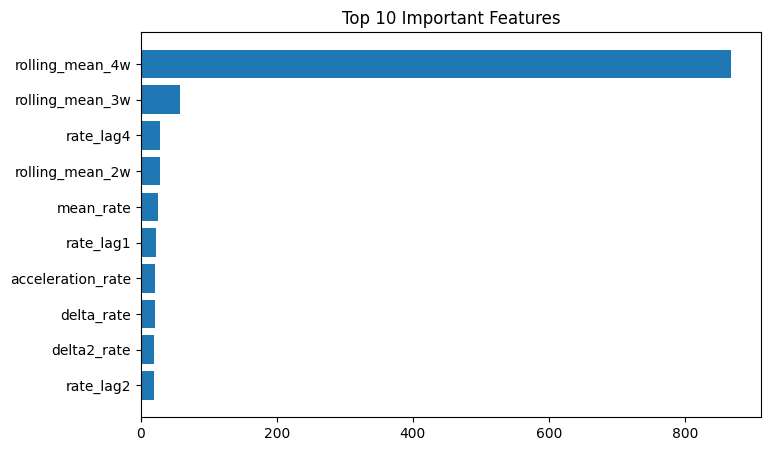

In [ ]:
#در این قسمت ویژگی هایی که ساختیم را بررسی می کنیم کدام یک تاثیر بیشتری داشته است در پیش بینی امتیاز
importance = model.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame({
    "feature": list(importance.keys()),
    "importance": list(importance.values())
}).sort_values("importance", ascending=False)

print(imp_df.head(10))

plt.figure(figsize=(8,5))
plt.barh(imp_df["feature"].head(10), imp_df["importance"].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features")
plt.show()
